<a href="https://colab.research.google.com/github/panagranit/Monte-Carlo-tic-tac-toe-first-and-second-move/blob/main/Copy_of_CO2_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DataFrame after initial loading:


,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,195,NaN,1958.202,315.71,314.44,-1 -,.99 -0.9,NaN
1,195,NaN,1958.287,317.45,315.16,-1 -,.99 -0.9,NaN
2,195,NaN,1958.369,317.51,314.69,-1 -,.99 -0.9,NaN
3,195,NaN,1958.454,317.27,315.15,-1 -,.99 -0.9,NaN
4,195,NaN,1958.537,315.87,315.20,-1 -,.99 -0.9,NaN


(812, 8)

DataFrame after filtering for 'average' > 0:


,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,195,NaN,1958.202,315.71,314.44,-1 -,.99 -0.9,NaN
1,195,NaN,1958.287,317.45,315.16,-1 -,.99 -0.9,NaN
2,195,NaN,1958.369,317.51,314.69,-1 -,.99 -0.9,NaN
3,195,NaN,1958.454,317.27,315.15,-1 -,.99 -0.9,NaN
4,195,NaN,1958.537,315.87,315.20,-1 -,.99 -0.9,NaN


(812, 8)

DataFrame after converting and dropping NaN in 'decimal_date':


,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,195,NaN,1958.202,315.71,314.44,-1 -,.99 -0.9,NaN
1,195,NaN,1958.287,317.45,315.16,-1 -,.99 -0.9,NaN
2,195,NaN,1958.369,317.51,314.69,-1 -,.99 -0.9,NaN
3,195,NaN,1958.454,317.27,315.15,-1 -,.99 -0.9,NaN
4,195,NaN,1958.537,315.87,315.20,-1 -,.99 -0.9,NaN


(812, 8)
Fitting polynomial of degree 3 with gradient descent...
Converged after 2557 iterations

Learned coefficients (from constant to highest degree):
[3.55390982e+02 3.18198847e+01 5.13199797e+00 3.06870066e-01]


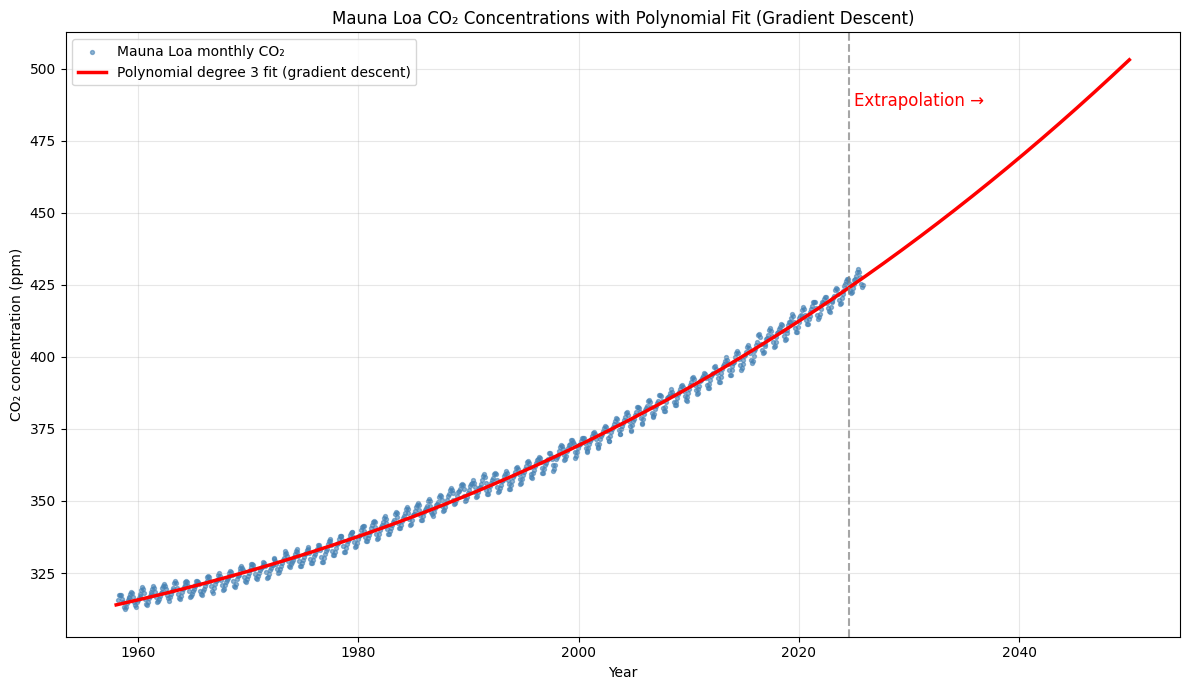


Predicted CO₂ concentration in 2050 ≈ 503.1 ppm


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 1. Download the latest Mauna Loa monthly CO2 data
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt"

# Column names and formatting for this specific text file
# Updated col_spec and names based on raw data inspection
col_spec = [(0, 4), (5, 8), (12, 21), (25, 35), (36, 46), (47, 57), (58, 68), (69, 79)]
names = ["year", "month", "decimal_date", "average", "deseasonalized", "ndays", "sdev", "unc"]

df = pd.read_fwf(url, colspecs=col_spec, names=names, comment='#', na_values=-99.99)

print("DataFrame after initial loading:")
display(df.head())
print(df.shape)

# Remove rows with missing average
df = df[df['average'] > 0].copy()

print("\nDataFrame after filtering for 'average' > 0:")
display(df.head())
print(df.shape)

# Convert 'decimal_date' to numeric
df['decimal_date'] = pd.to_numeric(df['decimal_date'], errors='coerce')
# Remove rows where 'decimal_date' could not be converted (became NaN)
df = df.dropna(subset=['decimal_date']).copy()

print("\nDataFrame after converting and dropping NaN in 'decimal_date':")
display(df.head())
print(df.shape)

# 2. Prepare X (years since 1958) and y (CO2 ppm)
df['years_since_1958'] = df['decimal_date'] - 1958.0
X = df['years_since_1958'].values
y = df['average'].values

# 3. Normalize X for better gradient descent behavior
X_mean, X_std = X.mean(), X.std()
X_norm = (X - X_mean) / X_std

# Choose polynomial degree (2 = quadratic, 3 = cubic, 4 = quartic, etc.)
degree = 3

# Build the design matrix for polynomial features
X_design = np.ones((len(X_norm), degree + 1))
for i in range(1, degree + 1):
    X_design[:, i] = X_norm ** i

# 4. Gradient descent
def gradient_descent(X, y, learning_rate=0.01, iterations=100000, tolerance=1e-8):
    m = len(y)
    theta = np.zeros(X.shape[1])          # parameters [θ0, θ1, θ2, ...]
    cost_history = []

    for it in range(iterations):
        predictions = X @ theta
        errors = predictions - y
        cost = np.sum(errors**2) / (2 * m)
        cost_history.append(cost)

        gradients = X.T @ errors / m
        theta_new = theta - learning_rate * gradients

        # Stop if parameters barely change
        if np.linalg.norm(theta_new - theta) < tolerance:
            print(f"Converged after {it+1} iterations")
            break

        theta = theta_new

        if (it+1) % 10000 == 0:
            print(f"Iteration {it+1:6d} | Cost: {cost:.3f}")

    return theta, cost_history

print("Fitting polynomial of degree", degree, "with gradient descent...")
theta, cost_hist = gradient_descent(X_design, y, learning_rate=0.05, iterations=150000)

print("\nLearned coefficients (from constant to highest degree):")
print(theta)

# 5. Predict up to 2050
future_years = np.linspace(1958, 2050, (2050-1958)*12 + 1)
future_years_since_1958 = future_years - 1958.0
future_norm = (future_years_since_1958 - X_mean) / X_std

future_design = np.ones((len(future_norm), degree + 1))
for i in range(1, degree + 1):
    future_design[:, i] = future_norm ** i

co2_future = future_design @ theta

# 6. Plot
plt.figure(figsize=(12, 7))
plt.scatter(df['decimal_date'], y, s=8, color='steelblue', alpha=0.6, label='Mauna Loa monthly CO₂')
plt.plot(future_years, co2_future, color='red', linewidth=2.5,
         label=f'Polynomial degree {degree} fit (gradient descent)')
plt.axvline(x=2024.5, color='gray', linestyle='--', alpha=0.7)
plt.text(2025, plt.ylim()[1]*0.95, 'Extrapolation →', color='red', fontsize=12, ha='left')

plt.title('Mauna Loa CO₂ Concentrations with Polynomial Fit (Gradient Descent)')
plt.xlabel('Year')
plt.ylabel('CO₂ concentration (ppm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print 2050 prediction
co2_2050 = co2_future[-1]
print(f"\nPredicted CO₂ concentration in 2050 \u2248 {co2_2050:.1f} ppm")